
FITTING RESULTS
---------------
Optimal Order Fit: 8
Chi-Squared Value: 301.2248140515768
Coefficients:
	x^8: 268.4970354288994
	x^7: -6879.270364622206
	x^6: 76716.49572367992
	x^5: -486365.67319701455
	x^4: 1917287.1700889117
	x^3: -4812471.0639346205
	x^2: 7511312.297974889
	x^1: -6665390.780870854
	x^0: 2574719.2286313092


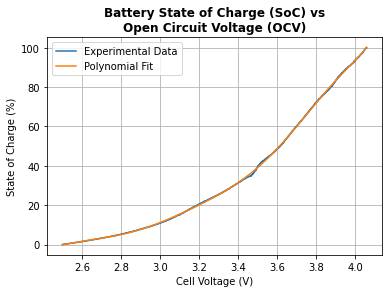

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def csvToList(fileName):
    dataFile = open(fileName, 'r')
    unformattedData = dataFile.readlines()
    formattedData = list()
    # get rid of column titles
    del unformattedData[0]
    # split the data by column, put in a formatted data list
    for line in unformattedData:
        currentLine = line.split(',')
        measurementNumber = int(currentLine[0])
        voltage = float(currentLine[1])
        formattedData.append([measurementNumber, voltage])
    dataFile.close()
    return formattedData

def findAnomalyIndex(dataList):
    anomalyIndexList = list()
    for i in range(len(dataList)):
        if i != 0:
            if dataList[i][1] - dataList[i-1][1] > .01:
                anomalyIndexList.append(i)
    return anomalyIndexList

def fixSingleAnomaly(anomalyIndex, dataSet):
    surroundingAverage = abs((dataSet[anomalyIndex + 1][1] + dataSet[anomalyIndex - 1][1])/2)
    dataSet[anomalyIndex][1] = surroundingAverage

def flipList(inputList):
    flippedList = list()
    for i in range(len(inputList)):
        flippedList.append(inputList[len(inputList) - i - 1])
    return flippedList

def createArray(listX, listY):
    newList = list()
    for i in range(len(listX)):
        newList.append([listX[i], listY[i]])
    return np.array(newList)

def createSpacedList(min, max, spacing):
    currentVal = min
    spacedList = list()
    i = 0
    while currentVal < max:
        currentVal = min + (i * spacing)
        spacedList.append(currentVal)
        i += 1
    return spacedList

def main():

    batteryData1 = csvToList("Raw Data.csv")

    # Separate measurement numbers and OCV readings into separate lists
    measurementNumbers1 = list()
    voltageReading1 = list()
    for data in batteryData1:
        measurementNumbers1.append(data[0])
        voltageReading1.append(data[1])

    # Find anomalies - used if discharge is interrupted or there are isolated noisy data points
    anomalies = findAnomalyIndex(batteryData1)

    # Fix any anomalies
    for anomaly in anomalies:
        fixSingleAnomaly(anomaly - 1, batteryData1)

    # Refresh the lists with the corrected noisy data points
    measurementNumbers1 = list()
    voltageReading1 = list()
    for data in batteryData1:
        measurementNumbers1.append(data[0])
        voltageReading1.append(data[1])

    # Flip the order of the lists to allow for the SoC vs OCV plot
    measurementsAdjusted = flipList(measurementNumbers1)
    voltageReadingFinal = flipList(voltageReading1)

    # Normalize the data measurement numbers on a 0 to 100% scale
    numMeasurements = len(measurementsAdjusted)
    increment = 100.0/numMeasurements
    normalizedSoC = list()
    tempI = 0
    while tempI < numMeasurements:
        normalizedSoC.append(tempI*increment)
        tempI += 1

    # ----------------------------------------------------------------------------
    # At this point, normalizedSoC is the Y-Value list
    # At this point, voltageReadingFinal is the anomaly-corrected X-Value list
    # ----------------------------------------------------------------------------

    # Finds the optimal order n of a polynomial fit of the data using minimum chi-square analysis
    optimalFitValues = findOptimalOrderFit(voltageReadingFinal, normalizedSoC)
    optimalOrder = optimalFitValues[0]

    # Creates a list of modeled SoC values using the optimal polynomial fit, used for plotting
    modeledValues = getPolyFitValues(optimalOrder, voltageReadingFinal, normalizedSoC)

    # Prints the optimal order n, chi-squared value of the fit, and coefficients of the polynomial fit
    print("\nFITTING RESULTS")
    print("---------------")
    printFittingResults(optimalFitValues, voltageReadingFinal, normalizedSoC)

    # PLOTTING
    # set showRawData = True to view raw data
    # set showRawData = False to just view the fitted data
    showRawData = False

    if showRawData:
        # Plots the raw OCV vs measurement number data
        plt.subplot(1, 2, 1)
        plt.plot(measurementNumbers1, voltageReading1, label='Raw Data')
        plt.legend(loc='best')
        plt.ylabel('Cell Voltage (V)')
        plt.xlabel('Measurement Number')
        plt.title("Raw Data - Open Circuit Voltage (OCV)\nvs Measurement Number", fontweight='bold')
        plt.grid(True)
        # Plots the experimental SoC vs OCV
        plt.subplot(1, 2, 2)
        plt.plot(voltageReadingFinal, normalizedSoC, label='Experimental Data')
        # Plots the modeled values using the polynomial fit for SoC vs OCV
        plt.plot(voltageReadingFinal, modeledValues, label='Polynomial Fit')
        plt.legend(loc='best')
        plt.ylabel('State of Charge (%)')
        plt.xlabel('Cell Voltage (V)')
        plt.title("Battery State of Charge (SoC) vs\nOpen Circuit Voltage (OCV)", fontweight='bold')
        plt.grid(True)
        # Adjust spacing of subplots
        plt.subplots_adjust(wspace=0.35)
    else:
        # Plots the experimental SoC vs OCV
        plt.plot(voltageReadingFinal, normalizedSoC, label='Experimental Data')
        # Plots the modeled values using the polynomial fit for SoC vs OCV
        plt.plot(voltageReadingFinal, modeledValues, label='Polynomial Fit')
        plt.legend(loc='best')
        plt.ylabel('State of Charge (%)')
        plt.xlabel('Cell Voltage (V)')
        plt.title("Battery State of Charge (SoC) vs\nOpen Circuit Voltage (OCV)", fontweight='bold')
        plt.grid(True)
        # Adjust spacing of subplots
        plt.subplots_adjust(wspace=0.35)

    plt.show()


main()